##Imports

In [ ]:
# Dataset
import kagglehub

# Basic data manipulation and visualization
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Deep learning imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Random functions
import random

seed = 100
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Loading & Visualizations

In [ ]:
# Download latest version of the dataset
path = kagglehub.dataset_download("lesliedalton/breast-cancer-grade")
BASE_PATH = path

# Define paths with correct nested structure
chtn_path = os.path.join(BASE_PATH, 'Folder_2_CHTN_train_images', 'Folder_2_CHTN_train_images')

print("Dataset paths:")
print(f"CHTN path: {chtn_path}")

# Function to check folder contents
def print_folder_contents(folder_path):
    try:
        contents = os.listdir(folder_path)
        print(f"\nContents of {os.path.basename(folder_path)}:")
        for item in contents:
            item_path = os.path.join(folder_path, item)
            if os.path.isdir(item_path):
                num_files = len([f for f in os.listdir(item_path)
                               if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))])
                print(f"- {item}: {num_files} images")
    except Exception as e:
        print(f"Error reading directory: {str(e)}")

# Check contents of both datasets

print("\nExamining CHTN dataset:")
print_folder_contents(chtn_path)

# Print the first few files in each folder to verify contents
def print_sample_files(folder_path, n=3):
    print(f"\nSample files in {os.path.basename(folder_path)}:")
    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        if os.path.isdir(subdir_path):
            files = [f for f in os.listdir(subdir_path)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]
            print(f"\n{subdir}:")
            for f in files[:n]:
                print(f"  - {f}")

print("\nSample files from CHTN:")
print_sample_files(chtn_path)

100%|██████████| 334M/334M [00:03<00:00, 105MB/s]

Extracting files...


Dataset paths:
CHTN path: /root/.cache/kagglehub/datasets/lesliedalton/breast-cancer-grade/versions/1/Folder_2_CHTN_train_images/Folder_2_CHTN_train_images

Examining CHTN dataset:

Contents of Folder_2_CHTN_train_images:
- High: 5191 images
- Stroma: 2928 images
- Low: 5222 images

Sample files from CHTN:

Sample files in Folder_2_CHTN_train_images:

High:
  - nbb56.jpg
  - imi-7-6.jpg
  - ihj-12-0.jpg

Stroma:
  - ihc100.jpg
  - ifr31.jpg
  - njd52.jpg

Low:
  - mbp15.jpg
  - nfa07.jpg
  - reb47.jpg


In [ ]:
# Define correct nested paths
CHTN_PATH = os.path.join(BASE_PATH, 'Folder_2_CHTN_train_images', 'Folder_2_CHTN_train_images')

# Print dataset statistics
categories = ['High', 'Low', 'Stroma']
dataset_stats = {
    'CHTN': {cat: len(os.listdir(os.path.join(CHTN_PATH, cat))) for cat in categories}
}

print("Dataset Statistics:")
print("\nCHTN Dataset:")
for category, count in dataset_stats['CHTN'].items():
    print(f"{category}: {count} images")

total_images = sum(dataset_stats['CHTN'].values())
print(f"\nTotal images in dataset: {total_images}")

Dataset Statistics:

CHTN Dataset:
High: 5191 images
Low: 5223 images
Stroma: 2928 images

Total images in dataset: 13342


Sample Images from CHTN Dataset:


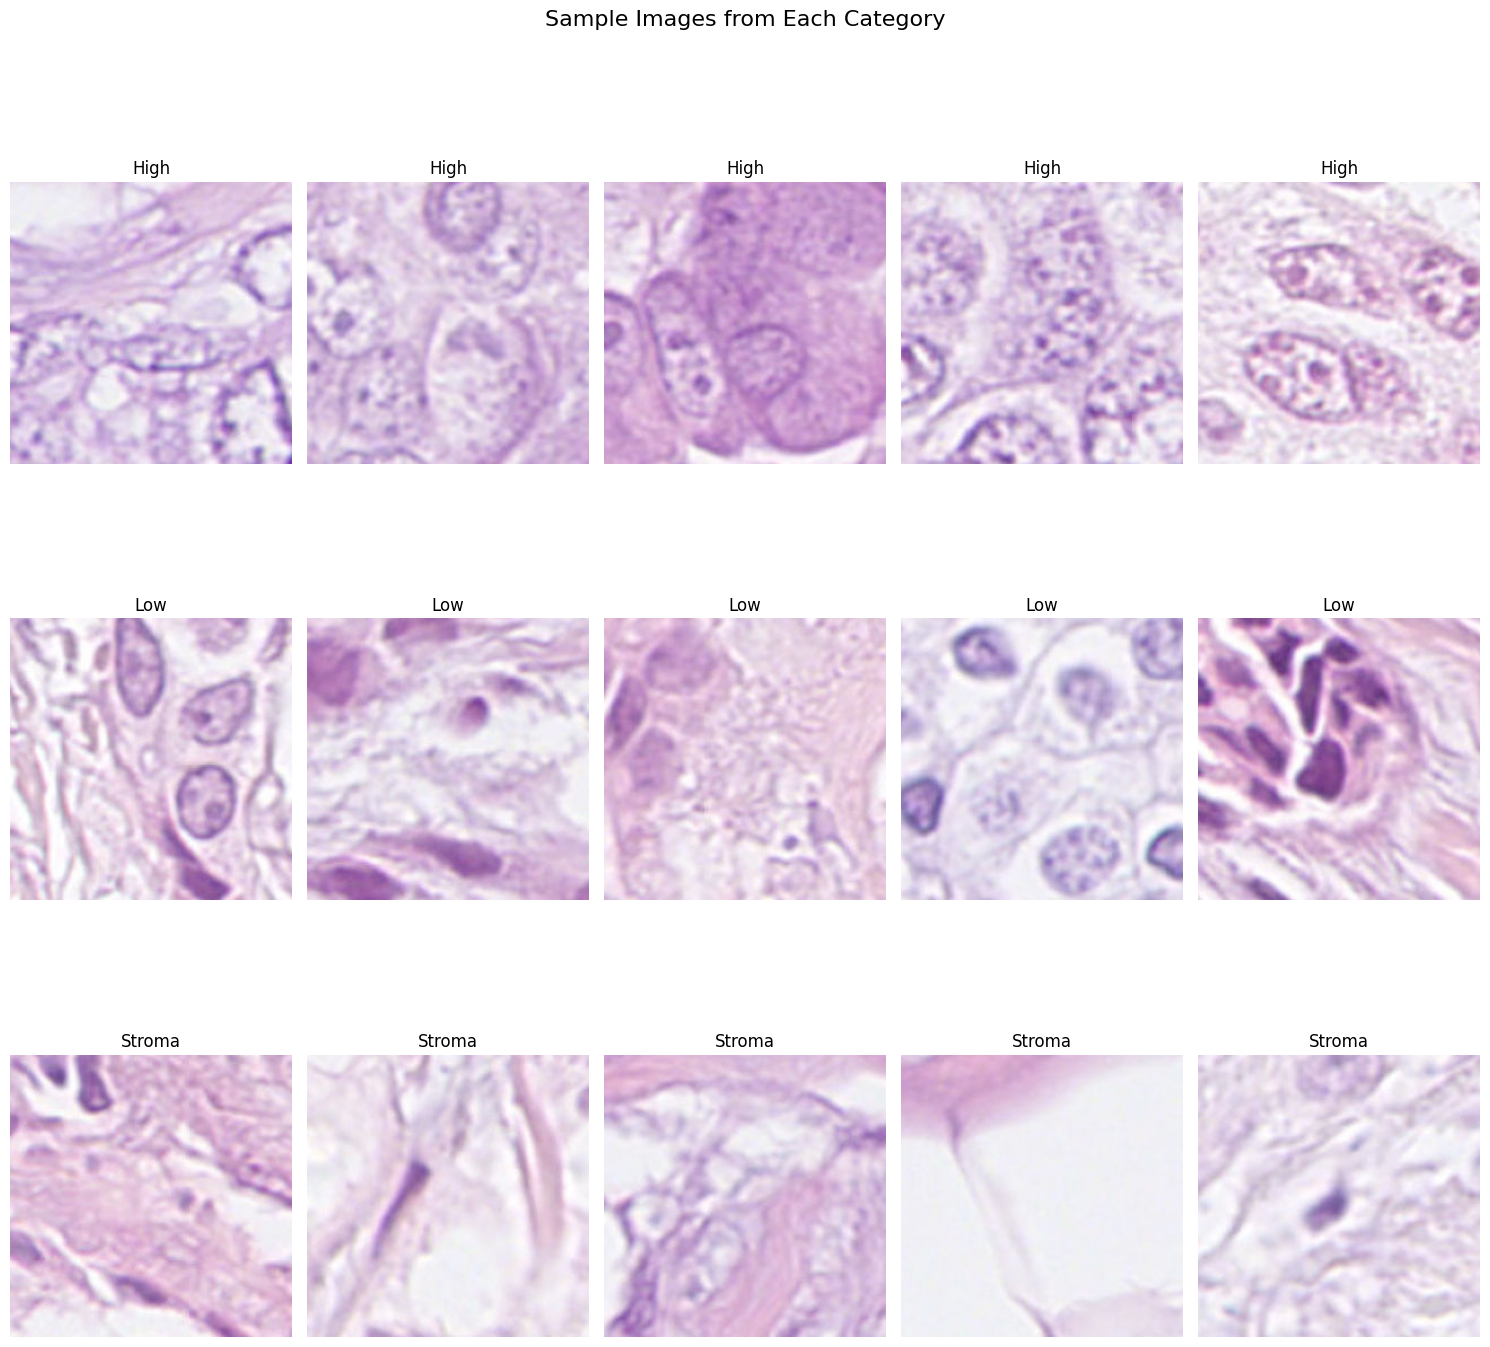

In [ ]:
def display_image_grid(base_path, categories, n_samples=5):
    """Display a grid of random images from each category for visual inspection."""
    fig, axes = plt.subplots(len(categories), n_samples, figsize=(15, 5 * len(categories)))
    fig.suptitle("Sample Images from Each Category", fontsize=16)

    for i, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        files = os.listdir(category_path)
        selected_files = random.sample(files, min(n_samples, len(files)))

        for j, file in enumerate(selected_files):
            file_path = os.path.join(category_path, file)
            img = Image.open(file_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{category}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Display image grids for TCGA and CHTN datasets

print("Sample Images from CHTN Dataset:")
display_image_grid(CHTN_PATH, categories, n_samples=5)


RGB Intensity Histograms for CHTN Dataset:


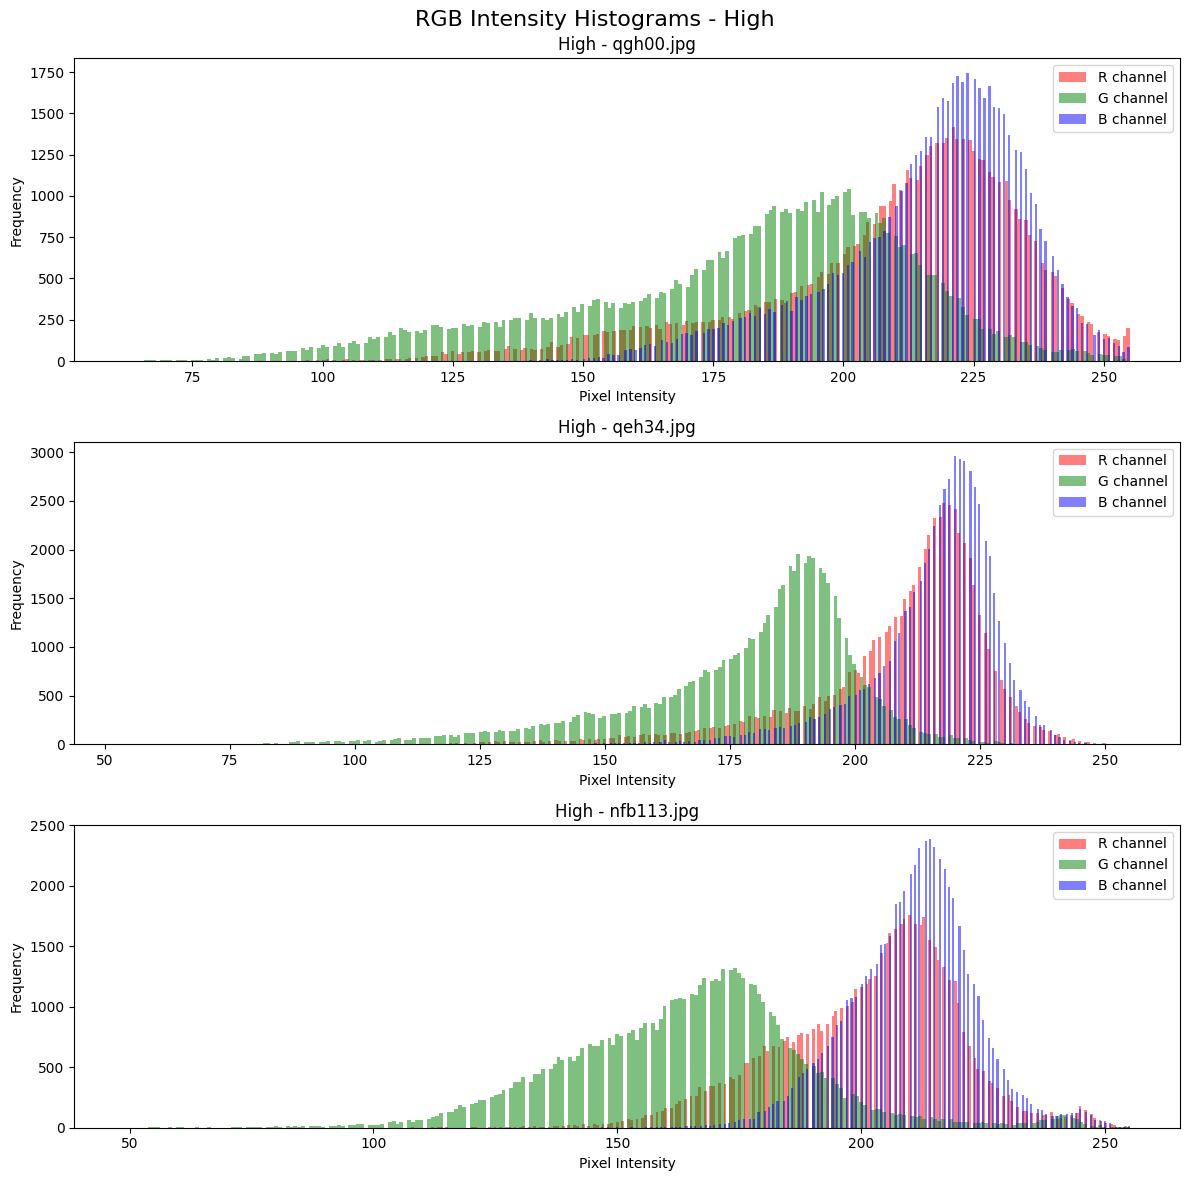

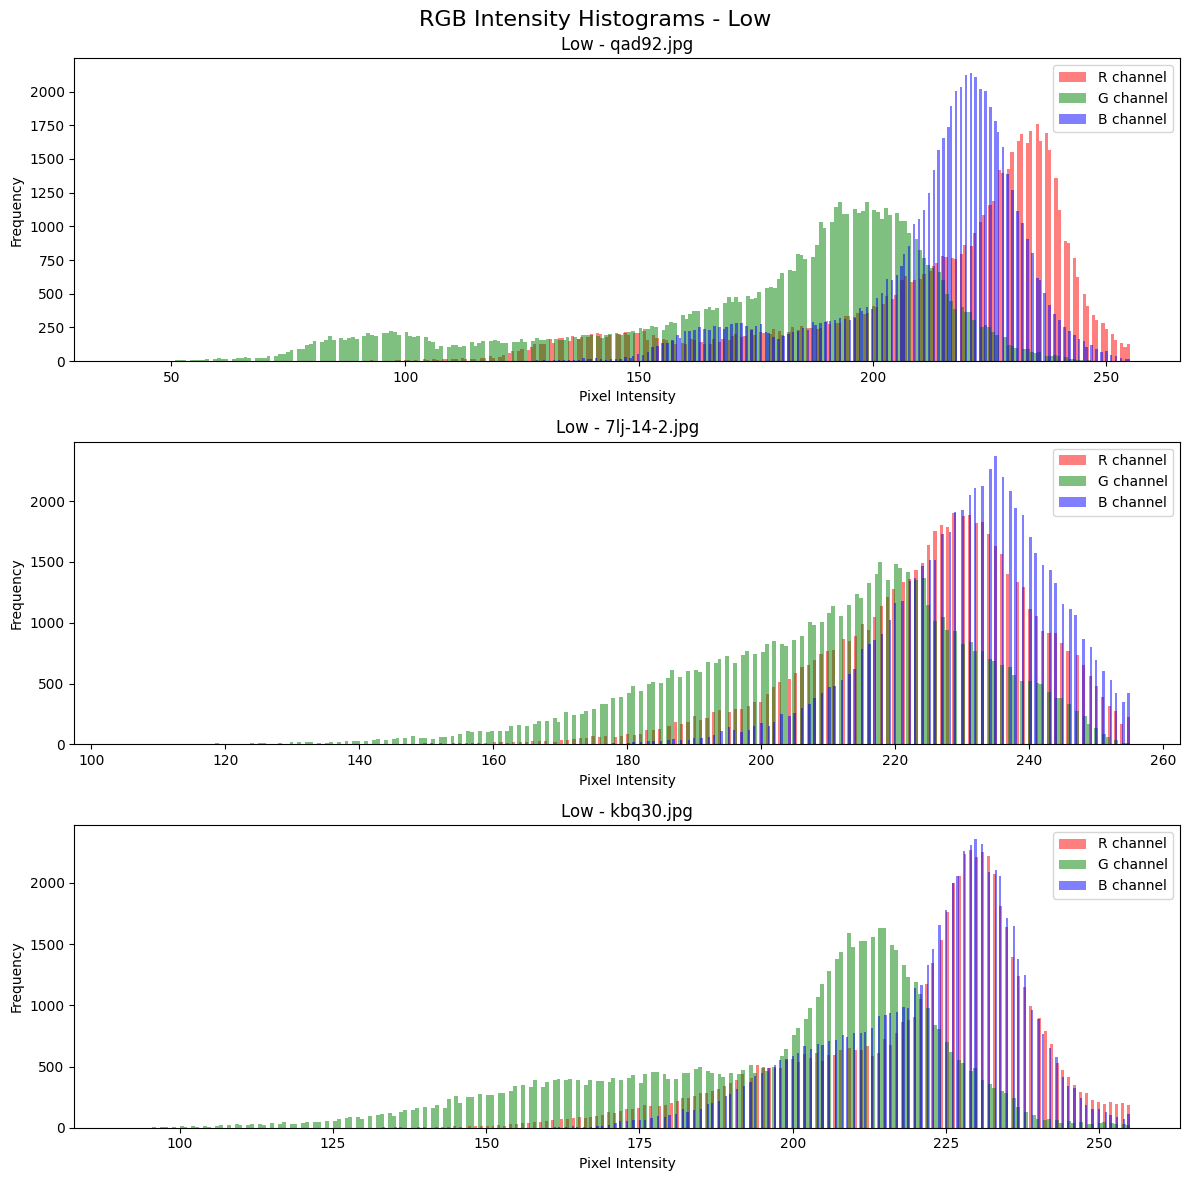

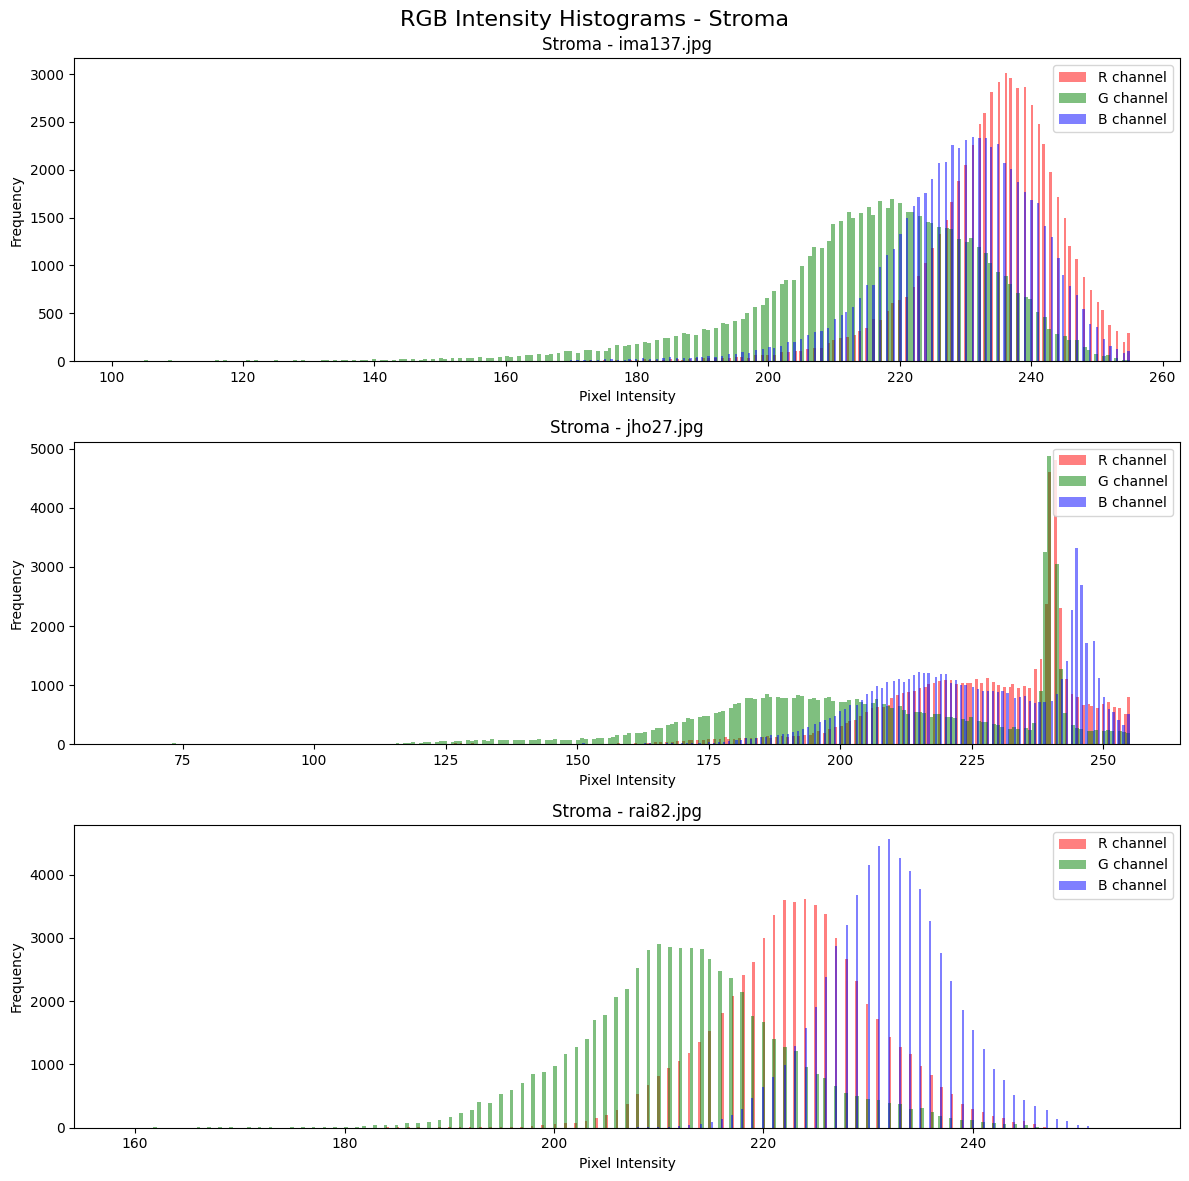

In [ ]:
def plot_intensity_histograms(base_path, categories, n_samples=3):
    """Plot intensity histograms for RGB channels of random images in each category."""
    colors = ['r', 'g', 'b']

    for category in categories:
        category_path = os.path.join(base_path, category)
        files = os.listdir(category_path)
        selected_files = random.sample(files, min(n_samples, len(files)))

        plt.figure(figsize=(12, 4 * n_samples))
        plt.suptitle(f"RGB Intensity Histograms - {category}", fontsize=16)

        for i, file in enumerate(selected_files):
            file_path = os.path.join(category_path, file)
            img = Image.open(file_path).convert('RGB')
            img_array = np.array(img)

            plt.subplot(n_samples, 1, i + 1)
            for j, color in enumerate(colors):
                plt.hist(img_array[..., j].ravel(), bins=256, color=color, alpha=0.5, label=f'{color.upper()} channel')
            plt.legend(loc='upper right')
            plt.title(f"{category} - {file}")
            plt.xlabel("Pixel Intensity")
            plt.ylabel("Frequency")

        plt.tight_layout()
        plt.show()

# Display intensity histograms for TCGA and CHTN datasets

print("RGB Intensity Histograms for CHTN Dataset:")
plot_intensity_histograms(CHTN_PATH, categories, n_samples=3)


Image Size Distribution for CHTN Dataset:


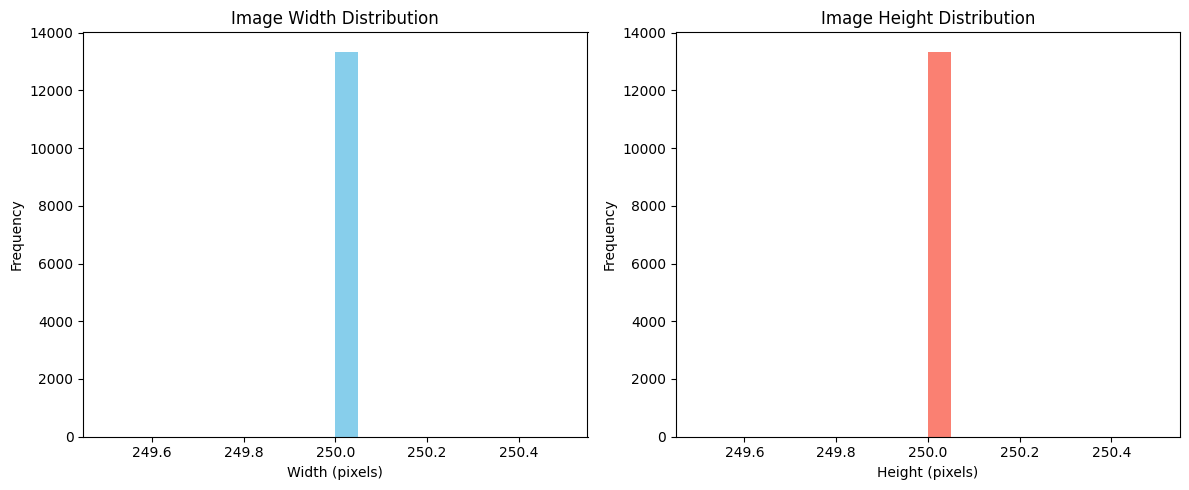

In [ ]:
def plot_image_size_distribution(base_path, categories):
    """Plot distribution of image sizes (width, height) across categories."""
    widths = []
    heights = []

    for category in categories:
        category_path = os.path.join(base_path, category)
        files = os.listdir(category_path)

        for file in files:
            file_path = os.path.join(category_path, file)
            try:
                img = Image.open(file_path)
                img.verify()
                img = Image.open(file_path)  # Reopen to get dimensions
                widths.append(img.size[0])
                heights.append(img.size[1])
            except (IOError, Image.UnidentifiedImageError):
                continue

    # Plot histograms for widths and heights
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color='skyblue')
    plt.title('Image Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color='salmon')
    plt.title('Image Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Display image size distribution for TCGA and CHTN datasets

print("Image Size Distribution for CHTN Dataset:")
plot_image_size_distribution(CHTN_PATH, categories)

##Initial CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os

# Paths
base_dir = chtn_path

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize images
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # Resize images to a fixed size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes
])

Found 10674 images belonging to 3 classes.
Found 2667 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Save the Model
model.save('breast_cancer_classifier.h5')

# Evaluate the Model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


333/333 ━━━━━━━━━━━━━━━━━━━━ 98s 270ms/step - accuracy: 0.3963 - loss: 1.0757 - val_accuracy: 0.5380 - val_loss: 0.9410
Epoch 2/25
  1/333 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.5625 - loss: 0.8821

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5625 - loss: 0.8821 - val_accuracy: 0.5455 - val_loss: 0.8684
Epoch 3/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 83s 245ms/step - accuracy: 0.6154 - loss: 0.8230 - val_accuracy: 0.6288 - val_loss: 0.8059
Epoch 4/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7500 - loss: 0.4786 - val_accuracy: 0.6364 - val_loss: 0.7724
Epoch 5/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 137s 249ms/step - accuracy: 0.7217 - loss: 0.6406 - val_accuracy: 0.6088 - val_loss: 0.8925
Epoch 6/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6562 - loss: 0.6868 - val_accuracy: 0.6364 - val_loss: 0.7861
Epoch 7/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 138s 252ms/step - accuracy: 0.7418 - loss: 0.6145 - val_accuracy: 0.6450 - val_loss: 0.8171
Epoch 8/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step - accuracy: 0.7188 - loss: 0.6779 - val_accuracy: 0.9091 - val_loss: 0.5508
Epoch 9/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 84s 247ms/step - accuracy: 0.7618 - loss: 0.5746 - val_accur

84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 190ms/step - accuracy: 0.6768 - loss: 0.8075
Validation Loss: 0.7929270267486572
Validation Accuracy: 0.6917885541915894


## More Convolutional Layers (5)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Paths
base_dir = chtn_path

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize images
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # Resize images to a fixed size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# CNN Model (Added Batch Normalization and more convolutional layers)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),

    # Removed excessive pooling to avoid shrinking below (4, 4)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Added dropout for regularization
    layers.Dense(3, activation='softmax')  # 3 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Increased epochs, but EarlyStopping will terminate early if no improvement
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Found 10674 images belonging to 3 classes.
Found 2667 images belonging to 3 classes.
Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 99s 270ms/step - accuracy: 0.7031 - loss: 0.9687 - val_accuracy: 0.2172 - val_loss: 4.1245
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.3274 - val_accuracy: 0.4545 - val_loss: 3.4555
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 83s 247ms/step - accuracy: 0.7827 - loss: 0.5707 - val_accuracy: 0.4074 - val_loss: 6.5627
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.6562 - loss: 0.6038 - val_accuracy: 0.3636 - val_loss: 6.9782
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 141s 246ms/step - accuracy: 0.8154 - loss: 0.4768 - val_accuracy: 0.4409 - val_loss: 2.6438
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - accuracy: 0.8438 - loss: 0.2709 - val_accuracy: 0.5455 - val_loss: 1.4155
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 142s 247ms/step - accuracy: 0.8362 - loss: 0.4361 - val_accuracy: 0.3923 - val_loss: 5.2621
E

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),

    # Removed excessive pooling to avoid shrinking below (4, 4)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Added dropout for regularization
    layers.Dense(3, activation='softmax')  # 3 classes
])

##Post Midterm Improvements

### Attempt 2: VGG16 + Random Forest

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# Set seed for reproducibility
# -----------------------------
seed = 45
np.random.seed(seed)
tf.random.set_seed(seed)

# -----------------------------
# Directory and Data Preparation
# -----------------------------
# Update this path to your dataset directory
path = kagglehub.dataset_download("lesliedalton/breast-cancer-grade")
base_dir = os.path.join(path, 'Folder_2_CHTN_train_images', 'Folder_2_CHTN_train_images')

# Class names (subdirectories) in the dataset
categories = ["High", "Low", "Stroma"]

# Use ImageDataGenerator to create training and validation splits
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # 20% for validation
)

# Parameters
batch_size = 32
img_size = (150, 150)

train_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=False # For consistent extraction of features
)

validation_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False # For consistent extraction of features
)

# -----------------------------
# Load Pre-trained Model (VGG16)
# -----------------------------
# We'll use VGG16 as a feature extractor by removing the top layers.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# Freeze the base_model weights
for layer in base_model.layers:
    layer.trainable = False

# -----------------------------
# Extract Features from Images
# -----------------------------
# Function to extract features using the pretrained model
def extract_features(generator, model):
    # Number of images = samples
    steps = np.ceil(generator.samples / generator.batch_size)
    features = []
    labels = []
    generator.reset()
    for i in range(int(steps)):
        img_batch, label_batch = next(generator)
        # Extract features
        batch_features = model.predict(img_batch, verbose=0)
        features.append(batch_features)
        labels.append(label_batch)
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

X_train, y_train = extract_features(train_generator, base_model)
X_val, y_val = extract_features(validation_generator, base_model)

# Flatten the features since VGG16 output is (4x4x512) for 150x150 input
# VGG16 output shape: (batch, 4,4,512) = 8192 features per image
X_train = X_train.reshape(X_train.shape[0], -1) # (num_samples, 4*4*512)
X_val = X_val.reshape(X_val.shape[0], -1)

# -----------------------------
# Train a Random Forest Classifier
# -----------------------------
# Get class indices to know label mapping
label_map = train_generator.class_indices
inv_label_map = {v: k for k, v in label_map.items()}

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=seed)
rf.fit(X_train, np.argmax(y_train, axis=1))

# -----------------------------
# Evaluate on Validation Set
# -----------------------------
y_pred = rf.predict(X_val)
y_true = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Found 10674 images belonging to 3 classes.
Found 2667 images belonging to 3 classes.
Classification Report:
              precision    recall  f1-score   support

        High       0.83      0.80      0.81      1038
         Low       0.73      0.82      0.77      1044
      Stroma       0.91      0.76      0.83       585

    accuracy                           0.80      2667
   macro avg       0.82      0.79      0.81      2667
weighted avg       0.81      0.80      0.80      2667

Confusion Matrix:
[[830 202   6]
 [149 859  36]
 [ 21 118 446]]


###Attempt 2: EfficientNetB0 + Random Forest

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

# -----------------------------
# Set seed for reproducibility
# -----------------------------
seed = 45
np.random.seed(seed)
tf.random.set_seed(seed)

# -----------------------------
# Download and Set Up Data
# -----------------------------
path = kagglehub.dataset_download("lesliedalton/breast-cancer-grade")
base_dir = os.path.join(path, 'Folder_2_CHTN_train_images', 'Folder_2_CHTN_train_images')

# Class names (subdirectories) in the dataset
categories = ["High", "Low", "Stroma"]

# -----------------------------
# Data Augmentation and Splitting
# -----------------------------
# Increase image size for better feature extraction
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Print class indices for sanity check
print("Classes found:", train_generator.class_indices)

# -----------------------------
# Load Pretrained Model
# -----------------------------
# Use EfficientNetB0 for potentially better features
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Unfreeze top layers for partial fine-tuning
# Let's say we unfreeze the top 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Build a small classifier head on top to fine-tune features
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])

# Compile the model for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),  # Lower lr for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune for a few epochs to improve representations
# (Adjust epochs as needed. More can lead to better representations but longer training.)
model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

# -----------------------------
# Feature Extraction (After Fine-Tuning)
# -----------------------------
# Now we use the fine-tuned base model (without the classifier head)
feature_model = models.Model(inputs=base_model.input, outputs=base_model.output)

# Function to extract features
def extract_features(generator, model):
    steps = np.ceil(generator.samples / generator.batch_size)
    features = []
    labels = []
    generator.reset()  # ensure we iterate over the dataset from start
    for _ in range(int(steps)):
        img_batch, label_batch = next(generator)
        batch_features = model.predict(img_batch, verbose=0)
        features.append(batch_features)
        labels.append(label_batch)
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

X_train, y_train = extract_features(train_generator, feature_model)
X_val, y_val = extract_features(validation_generator, feature_model)

# Flatten features
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

# -----------------------------
# Train a Random Forest Classifier on Extracted Features
# -----------------------------
rf = RandomForestClassifier(n_estimators=300, random_state=seed)  # Increased n_estimators
rf.fit(X_train, np.argmax(y_train, axis=1))

# -----------------------------
# Evaluate on Validation Set
# -----------------------------
y_pred = rf.predict(X_val)
y_true = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Found 10674 images belonging to 3 classes.
Found 2667 images belonging to 3 classes.
Classes found: {'High': 0, 'Low': 1, 'Stroma': 2}
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


334/334 ━━━━━━━━━━━━━━━━━━━━ 187s 471ms/step - accuracy: 0.6315 - loss: 0.7719 - val_accuracy: 0.8320 - val_loss: 0.4243
Epoch 2/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 132s 388ms/step - accuracy: 0.8216 - loss: 0.4414 - val_accuracy: 0.8410 - val_loss: 0.3880
Epoch 3/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 131s 384ms/step - accuracy: 0.8487 - loss: 0.3845 - val_accuracy: 0.8545 - val_loss: 0.3658
Epoch 4/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 142s 384ms/step - accuracy: 0.8556 - loss: 0.3593 - val_accuracy: 0.8586 - val_loss: 0.3623
Epoch 5/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 131s 384ms/step - accuracy: 0.8692 - loss: 0.3330 - val_accuracy: 0.8710 - val_loss: 0.3433
Classification Report:
              precision    recall  f1-score   support

        High       0.91      0.90      0.90      1038
         Low       0.79      0.89      0.84      1044
      Stroma       0.93      0.71      0.80       585

    accuracy                           0.86      2667
   macro avg       0.87      0.83      0.85      2667
weight

###Attempt 3: EfficientNetB3 + Random Forest

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras import layers, models, callbacks
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

# -----------------------------
# Set seed for reproducibility
# -----------------------------
seed = 45
np.random.seed(seed)
tf.random.set_seed(seed)

# -----------------------------
# Download and Set Up Data
# -----------------------------
path = kagglehub.dataset_download("lesliedalton/breast-cancer-grade")
base_dir = os.path.join(path, 'Folder_2_CHTN_train_images', 'Folder_2_CHTN_train_images')

# Class names (subdirectories) in the dataset
categories = ["High", "Low", "Stroma"]

# -----------------------------
# Data Augmentation and Splitting
# -----------------------------
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print("Classes found:", train_generator.class_indices)

# -----------------------------
# Load Pretrained Model (EfficientNetB3 with ImageNet weights)
# -----------------------------
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Unfreeze top layers for partial fine-tuning
# We can unfreeze more layers since this is a bigger model.
# For example, unfreeze the top 40 layers:
for layer in base_model.layers[:-40]:
    layer.trainable = False
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Build a classifier head on top to fine-tune features
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])

# Compile the model for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # low lr for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks: EarlyStopping and ReduceLROnPlateau
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1
)

# Fine-tune for more epochs to improve representations
model.fit(
    train_generator,
    epochs=15,  # increased epochs
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# -----------------------------
# Feature Extraction (After Fine-Tuning)
# -----------------------------
feature_model = models.Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(generator, model):
    steps = np.ceil(generator.samples / generator.batch_size)
    features = []
    labels = []
    generator.reset()
    for _ in range(int(steps)):
        img_batch, label_batch = next(generator)
        batch_features = model.predict(img_batch, verbose=0)
        features.append(batch_features)
        labels.append(label_batch)
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

X_train, y_train = extract_features(train_generator, feature_model)
X_val, y_val = extract_features(validation_generator, feature_model)

# Flatten features
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

# -----------------------------
# Train a Random Forest Classifier on Extracted Features
# -----------------------------
# Try tuning Random Forest hyperparameters
rf = RandomForestClassifier(
    n_estimators=500,         # more trees
    max_depth=50,             # limit depth
    min_samples_split=4,      # slightly larger min samples split
    random_state=seed
)
rf.fit(X_train, np.argmax(y_train, axis=1))

# -----------------------------
# Evaluate on Validation Set
# -----------------------------
y_pred = rf.predict(X_val)
y_true = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

100%|██████████| 334M/334M [00:10<00:00, 34.0MB/s]

Extracting files...


Found 10674 images belonging to 3 classes.
Found 2667 images belonging to 3 classes.
Classes found: {'High': 0, 'Low': 1, 'Stroma': 2}
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


334/334 ━━━━━━━━━━━━━━━━━━━━ 245s 572ms/step - accuracy: 0.6731 - loss: 0.7146 - val_accuracy: 0.8451 - val_loss: 0.4056 - learning_rate: 1.0000e-04
Epoch 2/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 184s 431ms/step - accuracy: 0.8399 - loss: 0.4141 - val_accuracy: 0.8586 - val_loss: 0.3655 - learning_rate: 1.0000e-04
Epoch 3/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 206s 442ms/step - accuracy: 0.8477 - loss: 0.3816 - val_accuracy: 0.8766 - val_loss: 0.3218 - learning_rate: 1.0000e-04
Epoch 4/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 153s 447ms/step - accuracy: 0.8624 - loss: 0.3495 - val_accuracy: 0.8654 - val_loss: 0.3563 - learning_rate: 1.0000e-04
Epoch 5/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 146s 430ms/step - accuracy: 0.8743 - loss: 0.3226 - val_accuracy: 0.8684 - val_loss: 0.3461 - learning_rate: 1.0000e-04
Epoch 6/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8860 - loss: 0.2933
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
334/334 ━━━━━━━━━━━━━━━━━━━━ 203s 433ms/step -

###Attempt 4:CNN from scratch

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

# -----------------------------
# Set seed for reproducibility
# -----------------------------
seed = 45
np.random.seed(seed)
tf.random.set_seed(seed)

# -----------------------------
# Download and Set Up Data
# -----------------------------
path = kagglehub.dataset_download("lesliedalton/breast-cancer-grade")
base_dir = os.path.join(path, 'Folder_2_CHTN_train_images', 'Folder_2_CHTN_train_images')

# Class names (subdirectories) in the dataset
categories = ["High", "Low", "Stroma"]

# -----------------------------
# Data Augmentation and Splitting
# -----------------------------
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Classes found:", train_generator.class_indices)

# -----------------------------
# Building a CNN from Scratch
# -----------------------------
# This is a starting point. You can adjust the number of filters,
# add more convolutional layers, or use regularization as needed.

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Block 4
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Global Pooling and Dense Layers
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1
)

# -----------------------------
# Training the CNN from Scratch
# -----------------------------
# Increase epochs as needed. Training from scratch might require more epochs.
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# -----------------------------
# Evaluation
# -----------------------------
# Predict on validation set
validation_generator.reset()
y_pred_proba = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = validation_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Found 10674 images belonging to 3 classes.
Found 2667 images belonging to 3 classes.
Classes found: {'High': 0, 'Low': 1, 'Stroma': 2}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 35/334 ━━━━━━━━━━━━━━━━━━━━ 4:05 821ms/step - accuracy: 0.6042 - loss: 0.8564

KeyboardInterrupt: 

Downloading from https://www.kaggle.com/api/v1/datasets/download/lesliedalton/breast-cancer-grade?dataset_version_number=1...
100%|██████████| 334M/334M [00:16<00:00, 21.7MB/s]Extracting files...

Found 10674 images belonging to 3 classes.
Found 2667 images belonging to 3 classes.
Classes found: {'High': 0, 'Low': 1, 'Stroma': 2}
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Epoch 1/20
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
334/334 ━━━━━━━━━━━━━━━━━━━━ 190s 487ms/step - accuracy: 0.7136 - loss: 0.6965 - val_accuracy: 0.2347 - val_loss: 2.3671 - learning_rate: 1.0000e-04
Epoch 2/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 160s 422ms/step - accuracy: 0.7928 - loss: 0.5152 - val_accuracy: 0.6190 - val_loss: 0.9477 - learning_rate: 1.0000e-04
Epoch 3/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 144s 423ms/step - accuracy: 0.8119 - loss: 0.4696 - val_accuracy: 0.7203 - val_loss: 0.7160 - learning_rate: 1.0000e-04
Epoch 4/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 142s 419ms/step - accuracy: 0.8237 - loss: 0.4489 - val_accuracy: 0.5066 - val_loss: 1.5629 - learning_rate: 1.0000e-04
Epoch 5/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 144s 423ms/step - accuracy: 0.8470 - loss: 0.4091 - val_accuracy: 0.7079 - val_loss: 0.7576 - learning_rate: 1.0000e-04
Epoch 6/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8477 - loss: 0.3948
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
334/334 ━━━━━━━━━━━━━━━━━━━━ 145s 423ms/step - accuracy: 0.8477 - loss: 0.3947 - val_accuracy: 0.6948 - val_loss: 0.8840 - learning_rate: 1.0000e-04
Epoch 7/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 143s 422ms/step - accuracy: 0.8640 - loss: 0.3558 - val_accuracy: 0.7642 - val_loss: 0.5754 - learning_rate: 2.0000e-05
Epoch 8/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 201s 420ms/step - accuracy: 0.8709 - loss: 0.3360 - val_accuracy: 0.7908 - val_loss: 0.5439 - learning_rate: 2.0000e-05
Epoch 9/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 142s 419ms/step - accuracy: 0.8823 - loss: 0.3118 - val_accuracy: 0.7953 - val_loss: 0.5226 - learning_rate: 2.0000e-05
Epoch 10/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 143s 420ms/step - accuracy: 0.8787 - loss: 0.3301 - val_accuracy: 0.7612 - val_loss: 0.6201 - learning_rate: 2.0000e-05
Epoch 11/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 141s 417ms/step - accuracy: 0.8802 - loss: 0.3067 - val_accuracy: 0.7784 - val_loss: 0.5692 - learning_rate: 2.0000e-05
Epoch 12/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8771 - loss: 0.3120
Epoch 12: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
334/334 ━━━━━━━━━━━━━━━━━━━━ 144s 424ms/step - accuracy: 0.8771 - loss: 0.3120 - val_accuracy: 0.7743 - val_loss: 0.5662 - learning_rate: 2.0000e-05
Epoch 13/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 144s 423ms/step - accuracy: 0.8833 - loss: 0.3027 - val_accuracy: 0.8129 - val_loss: 0.4834 - learning_rate: 4.0000e-06
Epoch 14/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 202s 419ms/step - accuracy: 0.8821 - loss: 0.3064 - val_accuracy: 0.8118 - val_loss: 0.4890 - learning_rate: 4.0000e-06
Epoch 15/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 202s 422ms/step - accuracy: 0.8838 - loss: 0.2972 - val_accuracy: 0.8001 - val_loss: 0.5002 - learning_rate: 4.0000e-06
Epoch 16/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 144s 425ms/step - accuracy: 0.8904 - loss: 0.2931 - val_accuracy: 0.8181 - val_loss: 0.4718 - learning_rate: 4.0000e-06
Epoch 17/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 144s 424ms/step - accuracy: 0.8840 - loss: 0.3032 - val_accuracy: 0.8024 - val_loss: 0.5032 - learning_rate: 4.0000e-06
Epoch 18/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 143s 421ms/step - accuracy: 0.8911 - loss: 0.2919 - val_accuracy: 0.7975 - val_loss: 0.5195 - learning_rate: 4.0000e-06
Epoch 19/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8920 - loss: 0.2926
Epoch 19: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
334/334 ━━━━━━━━━━━━━━━━━━━━ 204s 424ms/step - accuracy: 0.8919 - loss: 0.2926 - val_accuracy: 0.8151 - val_loss: 0.4819 - learning_rate: 4.0000e-06
Epoch 20/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 142s 419ms/step - accuracy: 0.8909 - loss: 0.2962 - val_accuracy: 0.8118 - val_loss: 0.4832 - learning_rate: 8.0000e-07
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step

Classification Report:
              precision    recall  f1-score   support

        High       0.89      0.74      0.81      1038
         Low       0.76      0.88      0.82      1044
      Stroma       0.83      0.85      0.84       585

    accuracy                           0.82      2667
    macro avg       0.83      0.82      0.82      2667
    weighted avg       0.83      0.82      0.82      2667

Confusion Matrix:

[[767 211  60]

 [ 82 920  42]

 [ 15  75 495]]

###Attempt 5: MobileNetV2 + Ensemble

In [ ]:
import os
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
import kagglehub
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import xgboost as xgb

# -----------------------------
# Set seed for reproducibility
# -----------------------------
seed = 45
np.random.seed(seed)
tf.random.set_seed(seed)

# -----------------------------
# Download Data
# -----------------------------
path = kagglehub.dataset_download("lesliedalton/breast-cancer-grade")
base_dir = os.path.join(path, 'Folder_2_CHTN_train_images', 'Folder_2_CHTN_train_images')

categories = ["High", "Low", "Stroma"]

# -----------------------------
# Try a slightly larger image size if memory allows
# -----------------------------
img_size = (96, 96)
batch_size = 16

datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Classes found:", train_generator.class_indices)

# -----------------------------
# Use MobileNetV2 for Feature Extraction
# -----------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96,96,3))
for layer in base_model.layers:
    layer.trainable = False

def extract_features(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    features = []
    labels = []
    generator.reset()
    for _ in range(steps):
        img_batch, label_batch = next(generator)
        batch_features = model.predict(img_batch, verbose=0)
        features.append(batch_features)
        labels.append(label_batch)
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

X_train, y_train = extract_features(train_generator, base_model)
X_val, y_val = extract_features(validation_generator, base_model)

# Flatten features
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Apply PCA with more components to retain more information
pca = PCA(n_components=512)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

del X_train, X_val, y_train, y_val
gc.collect()

xgb_model = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=45,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_pca, y_train_labels)
gc.collect()

y_pred_xgb = xgb_model.predict(X_val_pca)
print("XGBoost Classification Report:")
print(classification_report(y_val_labels, y_pred_xgb, target_names=["High", "Low", "Stroma"]))

# -----------------------------
# Train LightGBM Classifier
# -----------------------------
lgb_model = lgb.LGBMClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=45
)
lgb_model.fit(X_train_pca, y_train_labels)
gc.collect()

y_pred_lgb = lgb_model.predict(X_val_pca)
print("\nLightGBM Classification Report:")
print(classification_report(y_val_labels, y_pred_lgb, target_names=["High", "Low", "Stroma"]))

# -----------------------------
# Train CatBoost Classifier
# -----------------------------
cat_model = CatBoostClassifier(
    iterations=150,
    learning_rate=0.05,
    depth=6,
    rsm=0.8,  # similar to colsample_bytree
    random_seed=45,
    verbose=False
)
cat_model.fit(X_train_pca, y_train_labels)
gc.collect()

y_pred_cat = cat_model.predict(X_val_pca)
print("\nCatBoost Classification Report:")
print(classification_report(y_val_labels, y_pred_cat, target_names=["High", "Low", "Stroma"]))

# -----------------------------
# Soft Voting Ensemble
# -----------------------------
# Get probability predictions
y_proba_xgb = xgb_model.predict_proba(X_val_pca)
y_proba_lgb = lgb_model.predict_proba(X_val_pca)
y_proba_cat = cat_model.predict_proba(X_val_pca)

# Average the probabilities
y_proba_ensemble = (y_proba_xgb + y_proba_lgb + y_proba_cat) / 3.0
y_pred_ensemble_soft = np.argmax(y_proba_ensemble, axis=1)

print("\nSoft Voting Ensemble Classification Report:")
print(classification_report(y_val_labels, y_pred_ensemble_soft, target_names=["High", "Low", "Stroma"]))
print("Soft Voting Ensemble Confusion Matrix:")
print(confusion_matrix(y_val_labels, y_pred_ensemble_soft))


Found 10674 images belonging to 3 classes.
Found 2667 images belonging to 3 classes.
Classes found: {'High': 0, 'Low': 1, 'Stroma': 2}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:31:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

        High       0.84      0.82      0.83      1038
         Low       0.75      0.80      0.78      1044
      Stroma       0.85      0.80      0.83       585

    accuracy                           0.81      2667
   macro avg       0.82      0.81      0.81      2667
weighted avg       0.81      0.81      0.81      2667

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 10674, number of used features: 512
[LightGBM] [Info] Start training from score -0.943980
[LightGBM] [Info] Start training from score -0.937978
[LightGBM] [Info] Start training from score -1.516379

LightGBM Classification Report:
              precision    recall  f1-score   support

        High       0.85      0.82      0.83   

###Atempt 6: EfficientNetB3 (Final Model with Highest Accuracy)

In [ ]:
import os
import numpy as np
import tensorflow as tf
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# Set seed for reproducibility
# -----------------------------
seed = 45
np.random.seed(seed)
tf.random.set_seed(seed)

# -----------------------------
# Download Data
# -----------------------------
path = kagglehub.dataset_download("lesliedalton/breast-cancer-grade")
base_dir = os.path.join(path, 'Folder_2_CHTN_train_images', 'Folder_2_CHTN_train_images')

categories = ["High", "Low", "Stroma"]

# -----------------------------
# Parameters
# -----------------------------
img_size = (224, 224)
batch_size = 16

# -----------------------------
# Data Augmentation
# -----------------------------
# Add more aggressive augmentation to improve generalization
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Classes found:", train_generator.class_indices)

# -----------------------------
# Build Model - EfficientNetB3
# -----------------------------
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224,224,3))
# Initially freeze the entire base_model
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# -----------------------------
# Initial Training (Top Layers Only)
# -----------------------------
# Train only the top layers to get a decent starting point
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# -----------------------------
# Fine-Tune Deeper Layers
# -----------------------------
# Unfreeze more layers of the base model for fine-tuning
# Let's unfreeze the top 50 layers of the base model as an example
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(1e-4),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune further
history_ft = model.fit(
    train_generator,
    epochs=20,  # More epochs for fine-tuning
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# -----------------------------
# Evaluation
# -----------------------------
# Evaluate the final model on validation data
val_generator_for_eval = val_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

y_pred_proba = model.predict(val_generator_for_eval, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = val_generator_for_eval.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred, labels=[0,1,2]))


100%|██████████| 334M/334M [00:18<00:00, 19.1MB/s]

Extracting files...


Found 10674 images belonging to 3 classes.
Found 2667 images belonging to 3 classes.
Classes found: {'High': 0, 'Low': 1, 'Stroma': 2}
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


668/668 ━━━━━━━━━━━━━━━━━━━━ 225s 277ms/step - accuracy: 0.6618 - loss: 0.7529 - val_accuracy: 0.7623 - val_loss: 0.5615 - learning_rate: 0.0010
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 150s 223ms/step - accuracy: 0.7382 - loss: 0.6071 - val_accuracy: 0.7968 - val_loss: 0.5066 - learning_rate: 0.0010
Epoch 3/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 147s 217ms/step - accuracy: 0.7579 - loss: 0.5764 - val_accuracy: 0.7792 - val_loss: 0.5127 - learning_rate: 0.0010
Epoch 4/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 204s 220ms/step - accuracy: 0.7606 - loss: 0.5632 - val_accuracy: 0.7889 - val_loss: 0.5024 - learning_rate: 0.0010
Epoch 5/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 201s 219ms/step - accuracy: 0.7707 - loss: 0.5549 - val_accuracy: 0.7450 - val_loss: 0.5571 - learning_rate: 0.0010
Epoch 6/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 144s 213ms/step - accuracy: 0.7588 - loss: 0.5729 - val_accuracy: 0.7837 - val_loss: 0.5070 - learning_rate: 0.0010
Epoch 7/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7680 - 

In [ ]:
model.save('final_final_model.keras')

In [ ]:
from google.colab import files
files.download('final_final_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

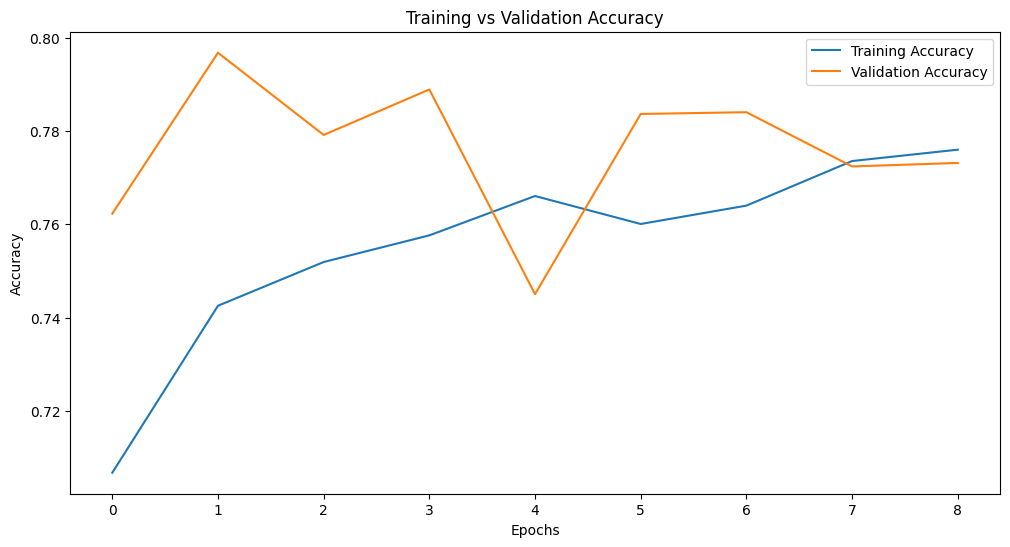

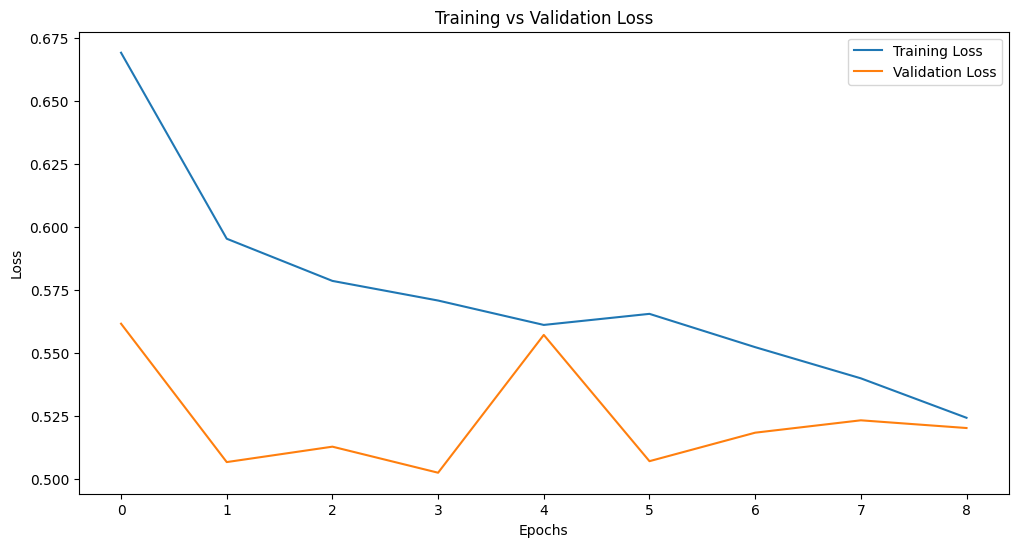

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


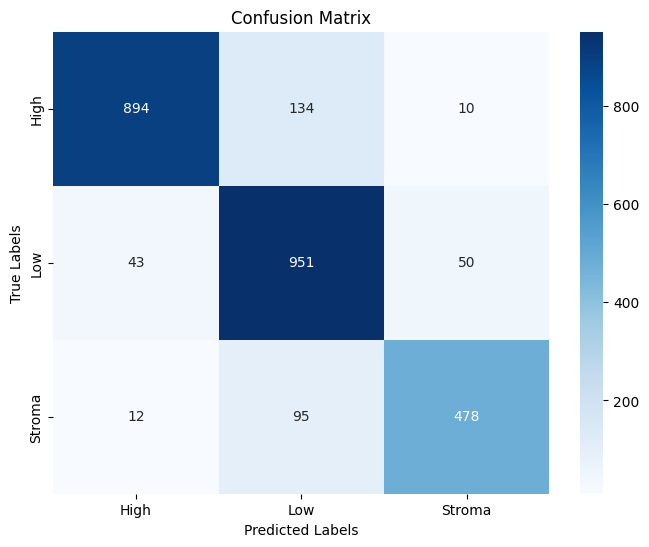

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


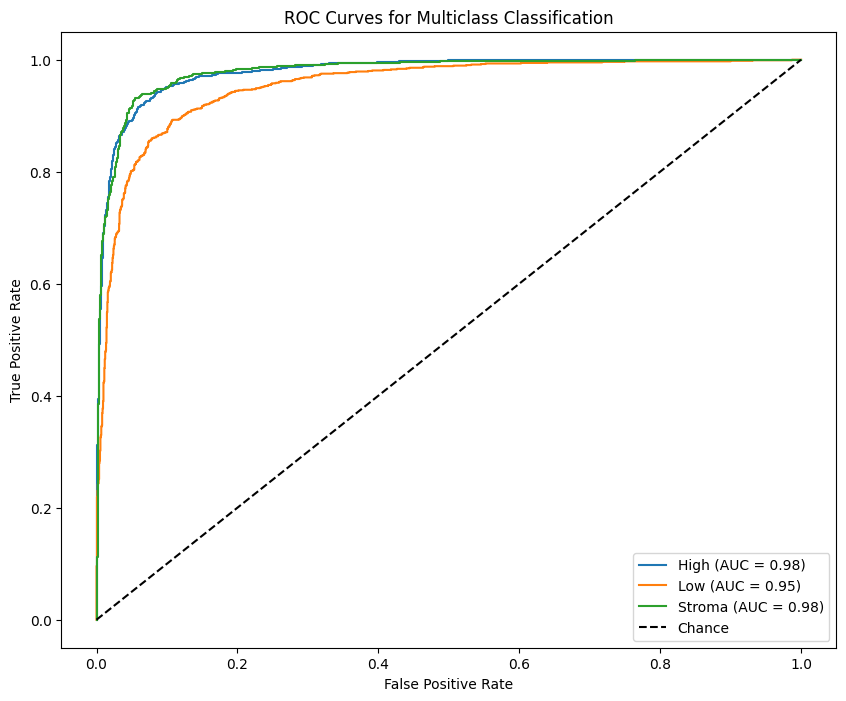

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, category in enumerate(categories):
    plt.plot(fpr[i], tpr[i], label=f'{category} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc='lower right')
plt.show()


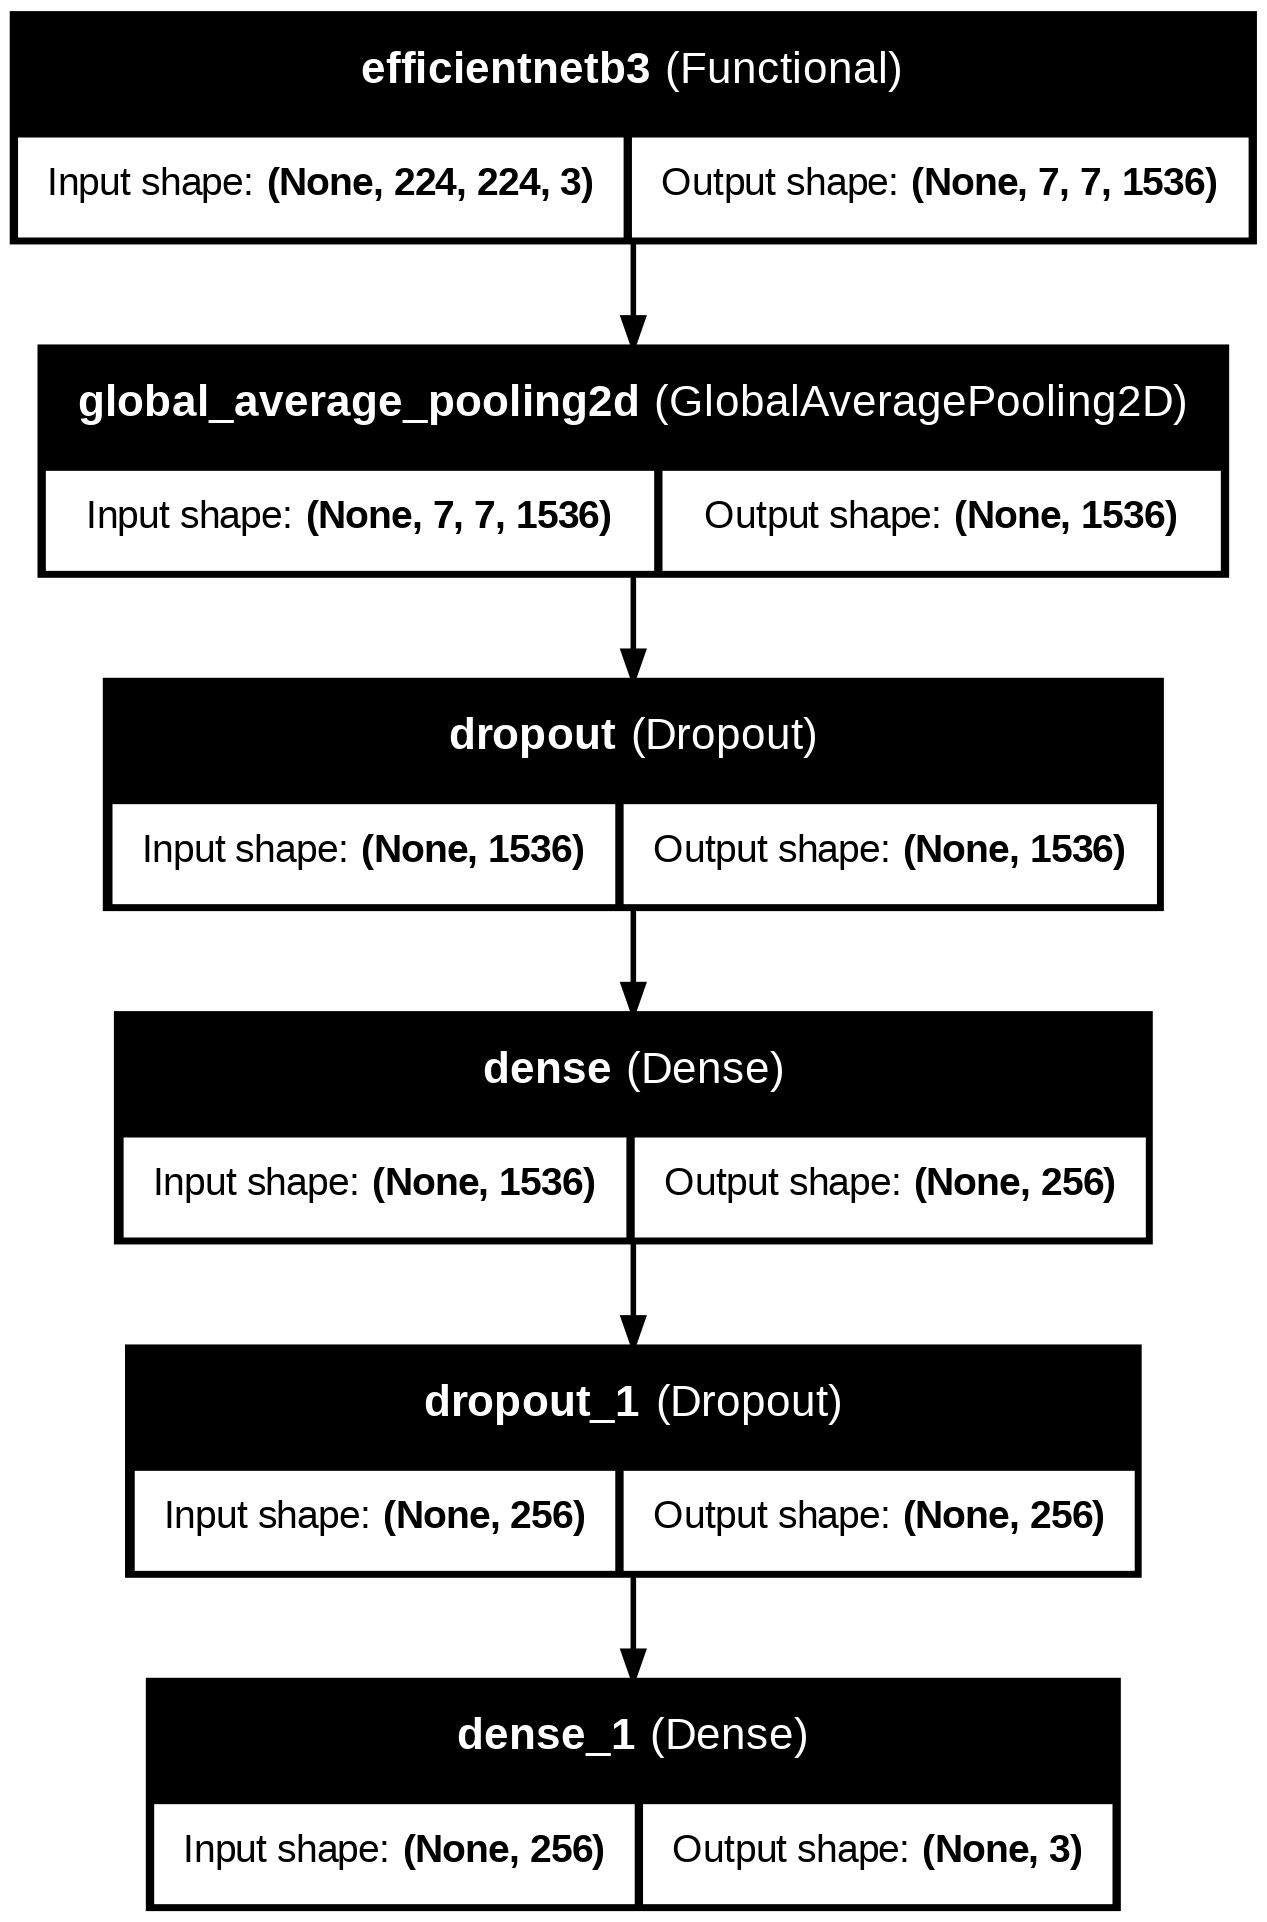

In [ ]:
import tensorflow
from tensorflow.keras.utils import plot_model
model = tensorflow.keras.models.load_model('final_final_model.keras')
# Save and display the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


Weights shape: (3, 3, 3, 40)


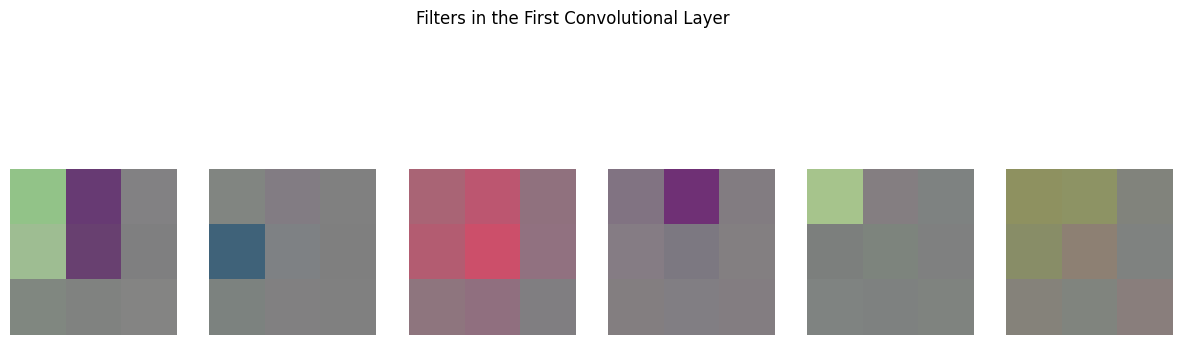

In [ ]:
# Extract the first convolutional layer
first_layer = model.layers[0].get_layer('stem_conv')  # Replace with the correct layer name
weights = first_layer.get_weights()

# Check the shape of the weights
print("Weights shape:", weights[0].shape)

# Visualize filters
filters = weights[0]  # This should represent the convolutional filters

# Normalize filter values to 0–1 for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot the first 6 filters
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    ax = axes[i]
    ax.imshow(filters[:, :, :, i], cmap='viridis')
    ax.axis('off')
plt.suptitle('Filters in the First Convolutional Layer')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


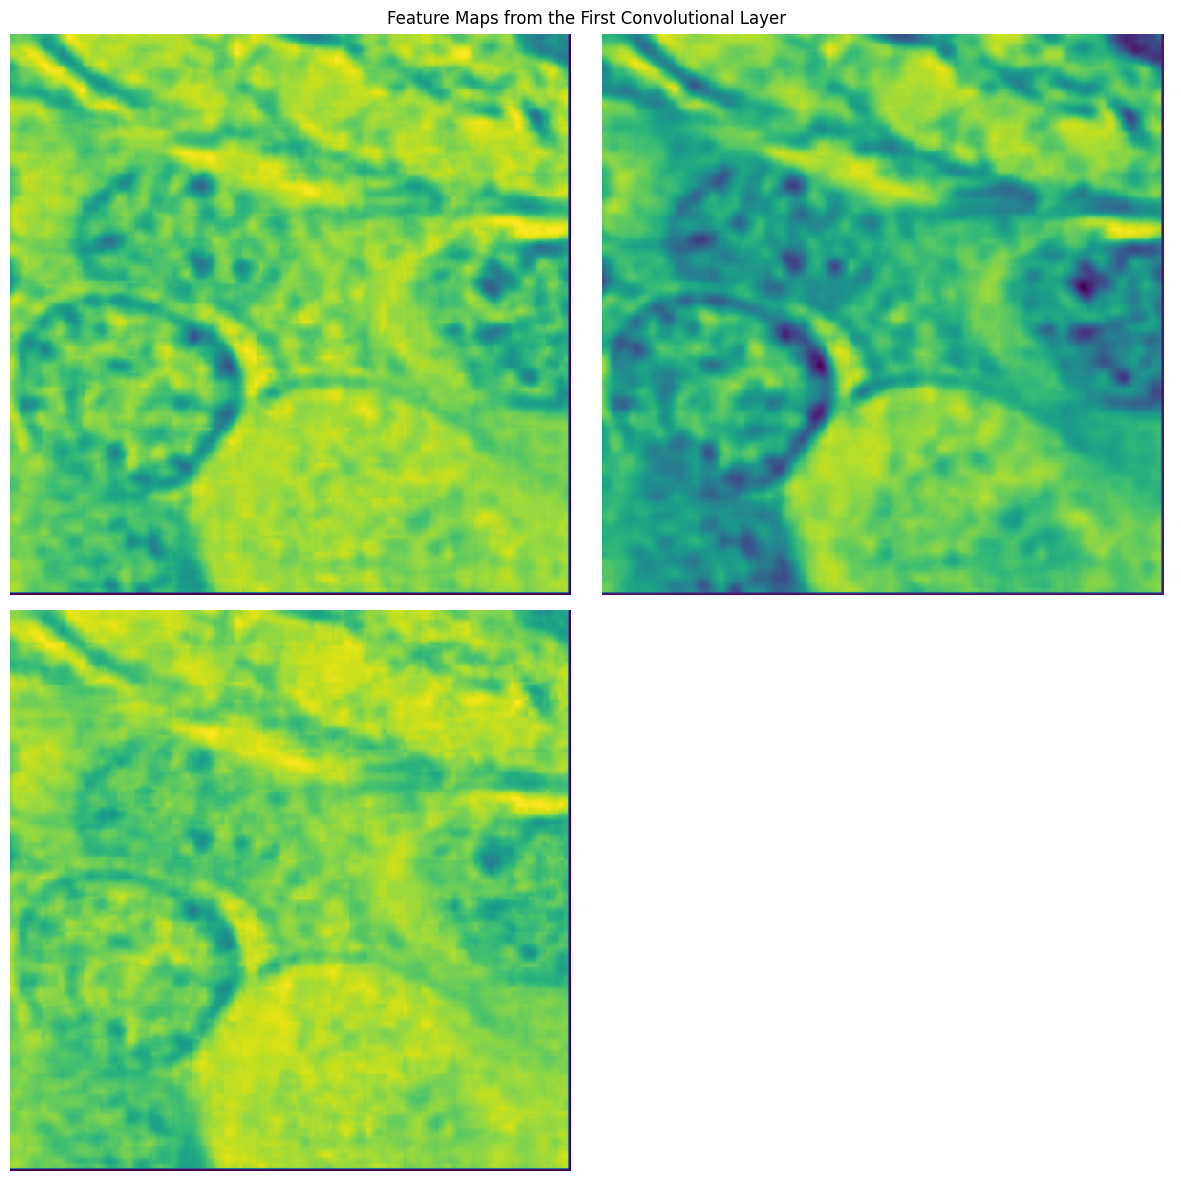

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load and preprocess a sample image
img_path = "3ab-3-3.jpg"  # Replace with the actual path to your image
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)  # Preprocess the image for EfficientNet

# Extract the EfficientNet base model from the Sequential model
efficientnet_base = model.layers[0]  # Assuming the first layer of Sequential is the EfficientNet base

# Define a model that outputs feature maps
layer_outputs = [layer.output for layer in efficientnet_base.layers if 'conv' in layer.name]
activation_model = tf.keras.models.Model(inputs=efficientnet_base.input, outputs=layer_outputs)

# Predict feature maps
activations = activation_model.predict(img_array)

# Plot feature maps of the first convolutional layer
first_layer_activation = activations[0]  # Feature maps from the first convolutional layer
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(16):
    ax = axes[i // 4, i % 4]
    ax.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    ax.axis('off')
plt.suptitle('Feature Maps from the First Convolutional Layer')
plt.show()
